# Import package 

In [1]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.octave import *
from qm.qua import *
from qm import generate_qua_script

#General os library 
import os
import time
import sys


import matplotlib.pyplot as plt
from qualang_tools.units import unit
from set_octave import get_L0_and_IF
from configuration_first_jump import *
from qm import SimulationConfig, LoopbackInterface
from qualang_tools.units import unit
from qualang_tools.loops import from_array
u = unit()
from qualang_tools.plot import interrupt_on_close
from qualang_tools.results import progress_counter, fetching_tool
from qualang_tools.addons.variables import assign_variables_to_element


sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Analysis_Function\NonLinearRes')
import AnFunc as an # analysis function
#import AnFunc as an 
import scipy.io
from scipy import signal 



In [2]:
def update_readout_lenght(Readout_Len,config,qmm):
    """ Macro to update the readout length in the configuration file"""
    
    #config["pulses"]["twoPhoton"]["length"]=5000 #Length of the pumping pulse
    config["pulses"]["zero_pulse"]["length"]=Readout_Len
    config["integration_weights"]["cosine_weights"]["cosine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["cosine_weights"]["sine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["sine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["sine"][0]=(-1.0, Readout_Len)


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm


def update_pulse_amplitude(pulse_amp,config,qmm):
    config["waveforms"]["const_wf"]['sample']=pulse_amp
    
    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config

def update_two_photon_lenght(twoPhoton_len,config,qmm):
    """ Update the length of the fluxline pulse in the configuration file"""

    config["pulses"]["twoPhoton"]["length"]=twoPhoton_len


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm

def update_time_of_flight(time_of_flight,config,qmm):
    """ Update the time_of_flight of the qm in the configuration file """
    config["elements"]["resonator"]["time_of_flight"]=time_of_flight
    
    qm=qmm.open_qm(config)
    
    return config, qm

# OPX configuration

In [3]:
#Octave & OPX configuration 

opx_ip = '128.178.175.167'
opx_port = 80
octave_ip = '128.178.175.167'
octave_port = 52


octave_config = QmOctaveConfig()
octave_config.set_calibration_db(os.getcwd()) #Path to the calibration database 

octave_config.add_device_info('octave1', octave_ip, octave_port) #Add a device refered to as octave 1
octave_config.set_opx_octave_mapping([('con1', 'octave1')])  # set default mapping between analog outputs of OPX and the octave


qmm = QuantumMachinesManager(host=opx_ip, port=opx_port, octave=octave_config)
qm = qmm.open_qm(config)


#Mixers for the fluxline 
qmm.octave_manager.set_clock("octave1", ClockType.External, ClockFrequency.MHZ_10) # External clock on the octave 
qm.octave.set_lo_source("fluxline", OctaveLOSource.Internal) # Use internal LO for the fluxline 
qm.octave.set_lo_frequency("fluxline", LO_fluxline)  # Set the frequency of the LO 
qm.octave.set_rf_output_gain("fluxline", -10)  # can set gain from -10dB to 20dB
qm.octave.set_rf_output_mode("fluxline", RFOutputMode.on)  # The LO output is always on (could change to a trigger)  #RFOutputMode.trig_normal

#Mixers for the resonator 
qm.octave.set_qua_element_octave_rf_in_port("resonator", "octave1", 1) #input port 1 is set for the resonator 
qm.octave.set_downconversion("resonator", lo_source=RFInputLOSource.Internal)  # The LO for the demodulation is the interal LO  
qm.octave.set_lo_frequency("resonator", LO_readout)  # assign the LO inside the octave to element

2023-04-11 21:54:26,930 - qm - INFO - Performing health check
2023-04-11 21:54:26,943 - qm - WARNING -   HC Warning: Potential hardware issue with QSync in controller con1, multiple controllers sync cannot be guaranteed, please inform QM
2023-04-11 21:54:26,943 - qm - INFO - Health check passed


In [4]:
#Setting the gain
gain=-6
config['controllers']['con1']['analog_inputs'][1]["gain_db"]=gain
config['controllers']['con1']['analog_inputs'][2]["gain_db"]=gain
qm = qmm.open_qm(config)

time_of_flight=24

config, qm=update_time_of_flight(time_of_flight,config,qmm)


# Testing the pump
Calibrates the pump and plays an infine tone to look at the spectrum analyzer

In [5]:
#Mixer Calibration 
#Calibration of the fluxline mixer 
qm.octave.calibrate_element("fluxline", [get_L0_and_IF(config, "fluxline")])  
qm = qmm.open_qm(config)

2023-04-09 16:02:00,660 - qm - INFO - Flags: 
2023-04-09 16:02:00,660 - qm - INFO - Compiling program
2023-04-09 16:02:08,667 - qm - INFO - Sending pre-compiled program to QOP


In [15]:
# Testing the pump 

with program() as TwoPhoton:
    with infinite_loop_():
        play("pumping"*amp(0.1), 'fluxline')
        
job = qm.execute(TwoPhoton)






2023-02-16 16:39:23,541 - qm - INFO - Flags: 
2023-02-16 16:39:23,541 - qm - INFO - Sending program to QOP
2023-02-16 16:39:23,568 - qm - INFO - Executing program


In [15]:
#Two stop the two photon pumping 
job.halt()

True

## Single measurement with sliced demodulation
Runs the IQ blob program for a single pump frequency that can be defined with IF pump. The demodulation frequency is automatically taken as half of the total pump frequency

Need to make sure that the new updated IF frequency doesn't go over 350 MHz. 

In [5]:
# I and Q time trace directly from OPX out to OPX IN 
%matplotlib qt

Readout_Len=100_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)


chunk_size = 10 #unit cycle 
n_chunks = Readout_Len//(4 * chunk_size) # chunk size

with program() as IQ_blobs:
    
    
    n = declare(int)
    i = declare(int)
    I_1 = declare(fixed, size=n_chunks)
    Q_1 = declare(fixed, size=n_chunks)
    I_2 = declare(fixed, size=n_chunks)
    Q_2 = declare(fixed, size=n_chunks)
    I = declare(fixed, size=n_chunks)
    Q = declare(fixed, size=n_chunks)
    I_st = declare_stream()
    Q_st = declare_stream()

    measure(
        "fake_readout",
        "resonator",
        None,
        demod.sliced("cos",I_1, chunk_size, "out1"),
        demod.sliced("sin",I_2, chunk_size, "out2"),
        demod.sliced("minus_sin",Q_1, chunk_size, "out1"),
        demod.sliced("cos",Q_2, chunk_size, "out2"),
    )
    with for_(i, 0, i<n_chunks, i+1):

        assign(I[i],I_1[i]+I_2[i])
        assign(Q[i],Q_1[i]+Q_2[i])

        save(I[i], I_st)
        save(Q[i], Q_st)

    #wait(cooldown_time, "resonator")

    with stream_processing():
        I_st.save_all("I")
        Q_st.save_all("Q")

        
        
simulation = False

if simulation:
    simulation_config = SimulationConfig(
        duration=8000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot()
    
else:
  
    # Live plotting
    fig = plt.figure()
    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q"], mode="live")
    interrupt_on_close(fig, job) 
    
    while results.is_processing():
    
        I, Q = results.fetch_all()
        I = u.demod2volts(I,4 * chunk_size)
        Q = u.demod2volts(Q,4 * chunk_size)

        time=np.arange(n_chunks)*(4 * chunk_size)

        plt.subplot(211)
        plt.cla()
        plt.title("IQ blobs")
        plt.plot(time, I, '.')
        plt.xlabel("time")
        plt.ylabel("I")
        plt.subplot(212)
        plt.plot(time, Q,'.')
        plt.xlabel("time")
        plt.ylabel("Q")
        plt.tight_layout()
        #plt.axis("equal")


2023-04-03 09:02:40,007 - qm - INFO - Flags: 
2023-04-03 09:02:40,008 - qm - INFO - Sending program to QOP
2023-04-03 09:02:41,824 - qm - INFO - Executing program
Execution stopped by user!


In [15]:
#Generate debug script 

from qm import generate_qua_script

sourceFile=open("debug.py","w")
print(generate_qua_script(IQ_blobs,config), file=sourceFile)
sourceFile.close()

In [5]:
%matplotlib qt

#Defines the pump IF frequency 
IF_pump=0.3004e9  # defines the IF of the pump 
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at an IF corresponding to half of the pump knowing the lo of the readout  


n_runs = 10 #Number of readout to do 

Readout_Delay = 16 //4 # Delay before the first readout in ns (convert from clockcycle)

amp_factor=0.5 #Prefactor of the amplitude of the fluxline pulse

Offset_IF=0  #offset around the half of the pump frequency 


#setting od the sliced demodulation
chunk_size=250 # size of each chunck in clock cycle 
n_chunks = pulse_len//(4 * chunk_size) # nb of chunks

with program() as IQ_blobs:
    
    f = declare(int)
    n = declare(int)
    i = declare(int)
    I_1 = declare(fixed, size=n_chunks)
    Q_1 = declare(fixed, size=n_chunks)
    I_2 = declare(fixed, size=n_chunks)
    Q_2 = declare(fixed, size=n_chunks)
    I = declare(fixed, size=n_chunks)
    Q = declare(fixed, size=n_chunks)
    I_st = declare_stream()
    Q_st = declare_stream()

    update_frequency("resonator",IF_resonator+Offset_IF) # Change the IF frequency of the resonator to demodulate more precisely 
    update_frequency("fluxline",IF_pump)
    
    #Play a continuous loop sending a pulse through the fluxline 
    with infinite_loop_():
        play("pumping"*amp(amp_factor), 'fluxline') #Play the pulse on the fluxline 

    
    #Delay time before the first readout 
    wait(Readout_Delay,"resonator")
    
    with for_(n, 0, n < n_runs, n + 1):
        
        #Sliced demod 
        measure(
            "cw",
            "resonator",
            None,
            demod.sliced("cos",I_1, chunk_size, "out1"),
            demod.sliced("sin",I_2, chunk_size, "out2"),
            demod.sliced("minus_sin",Q_1, chunk_size, "out1"),
            demod.sliced("cos",Q_2, chunk_size, "out2"),
        )

        #
        with for_(i, 0, i<n_chunks, i+1):

            assign(I[i],I_1[i]+I_2[i])
            assign(Q[i],Q_1[i]+Q_2[i])
            save(I[i], I_st)
            save(Q[i], Q_st)


    with stream_processing():
        I_st.with_timestamps().save_all("I")
        Q_st.with_timestamps().save_all("Q")

        
        
simulation = False

if simulation:
    simulation_config = SimulationConfig(
        duration=50000)
    
    
    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

    
    
else:
  

    job = qm.execute(IQ_blobs)
    
    
#     results = fetching_tool(job, data_list=["I", "Q"], mode="live")
    
#     # Live plotting
#     fig = plt.figure()
#     interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    
#     while results.is_processing():
#         I, Q = results.fetch_all()
        
#         dt=(I["timestamp"][1]-I["timestamp"][0])*1e-9 #time between sucessive points
#         I = u.demod2volts(I["value"], pulse_len) #diviser par la duree du pulse 
#         Q = u.demod2volts(Q["value"], pulse_len)

#         #plt.subplot(211)
        
#         plt.title("IQ blobs")
#         plt.subplot(211)
#         plt.cla()
#         plt.plot(I[:min(len(I), len(Q))], Q[:min(len(I), len(Q))], ".", markersize=2)
#         plt.xlabel("I")
#         plt.ylabel("Q")
#         plt.axis("equal")
#         plt.subplot(212)
#         plt.cla()
#         tau=np.linspace(1,min(len(I), len(Q)),min(len(I), len(Q)))
#         plt.plot(np.unwrap(np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))])), ".", markersize=2)
#         plt.xlabel("Nb points")
#         plt.ylabel("phase")
#         plt.pause(0.1)
#         #plt.axis("equal")
#         #job.halt()
        

2023-03-31 10:40:15,694 - qm - INFO - Flags: 
2023-03-31 10:40:15,695 - qm - INFO - Sending program to QOP
2023-03-31 10:40:15,913 - qm - INFO - Executing program


In [ ]:
# Plotting 

fig = plt.figure()
plt.title("Pump frequency : "+str(LO_fluxline+IF_pump))
plt.subplot(211)
plt.plot(I, Q, ".", markersize=2)
plt.xlabel("I (V)")
plt.ylabel("Q (V)")
plt.axis("equal")
plt.subplot(212)
tau=np.linspace(1,len(I), len(I),len(I))*dt*10e6 # time in micro seconds
plt.plot(np.unwrap(np.angle(I+1j*Q)), ".", markersize=2)
plt.xlabel("Time (us)")
plt.ylabel("Phase")


fig = plt.figure()
plt.hist2d(I,Q,bins=100);
plt.xlabel("I (V)")
plt.ylabel("Q (V)")
plt.axis("equal")

(-5.227413940429688e-05,
 4.778130340576172e-05,
 -8.06912612915039e-05,
 7.703717041015626e-05)

In [127]:
#Saving the data
cooldown_date="2023_03_17"
meastype="single_IQ_trace" #Final file name 
name="Run01"
device="123"

datadict={}
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_pump
datadict=["IF_readout"]=IF_resonator
datadict=["LO_readout"]=LO_readout


datadict["n_runs"]=n_runs
datadict["amp_factor"]=amp_factor
datadict["Offset_IF"]=Offset_IF
datadict["Readout_Len"]=Readout_Len
datadict["Readout_Delay"]=Readout_Delay
datadict["I"]=I
datadict["Q"]=Q
datadict["tau"]=tau

an.save_data(datadict, meastype, name, device, cooldown_date, bias=0, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")

## Single measurement with dual demodulation

Here, we wait for a certain before playing the pump. We need to make sure that the readout_len is much smaller than the pump delay if we want to capture the moment the pump turns on

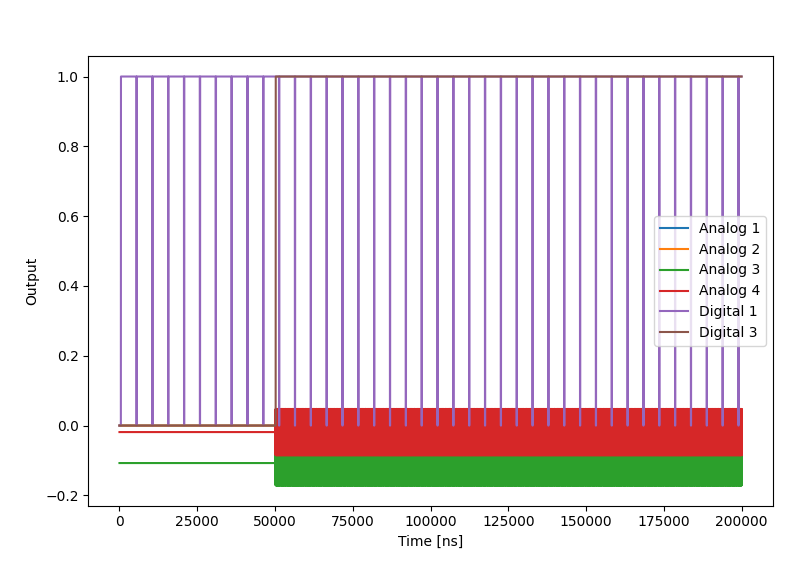


In [18]:
%matplotlib qt

Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

amp_factor=0.3 #Prefactor of the amplitude 

#Update the pump IF frequency 
IF_pump= 0.19681e9# defines the IF of the pump  
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 


n_runs = 100_000 #Number of readout to do 
Pump_Delay = 1000000000 //4 # Delay before the first readout in ns (convert from clockcycle)
Offset_IF=0  

with program() as IQ_blobs:
    
    n = declare(int)
    i = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    f = declare(int)

    update_frequency("resonator",IF_resonator+Offset_IF) 
    update_frequency("fluxline",IF_pump)
    
    #Delay time before turning the pump on 
    wait(Pump_Delay,"fluxline")
    
    with infinite_loop_():
        play("pumping"*amp(amp_factor), 'fluxline') #Play the pulse on the fluxline 
    
    with for_(n, 0, n < n_runs, n + 1):
        
        #Demodulate n time 
        measure(
            "fake_readout",
            "resonator",
            None,
            dual_demod.full("cos", "out1", "sin", "out2", I),
            dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
        )

        save(I, I_st)
        save(Q, Q_st)
        
    with stream_processing():
        I_st.with_timestamps().save_all("I")
        Q_st.with_timestamps().save_all("Q")

        
        
simulation = False 

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    
    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

    
    
else:
  

    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q"], mode="live")
    
    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    
    while results.is_processing():
        I, Q = results.fetch_all()
        
        dt=(I["timestamp"][1]-I["timestamp"][0])*1e-9 #time between sucessive points
        I = u.demod2volts(I["value"], pulse_len) #diviser par la duree du pulse 
        Q = u.demod2volts(Q["value"], pulse_len)

        plt.title("IQ blobs")
        plt.subplot(211)
        plt.cla()
        plt.plot(I[:min(len(I), len(Q))], Q[:min(len(I), len(Q))], ".", markersize=2)
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.axis("equal")
        plt.subplot(212)
        plt.cla()
        tau=np.linspace(1,min(len(I), len(Q)),min(len(I), len(Q)))
        plt.plot(tau,np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))]), ".", markersize=2)
        plt.plot([round(Pump_Delay*1e-9*4/dt),round(Pump_Delay*1e-9*4/dt)], [-np.pi, np.pi],'r')
        plt.xlabel("Nb points")
        plt.ylabel("phase")
        plt.pause(0.1)
      
time=np.linspace(1,len(I), len(I),len(I))*dt

2023-04-08 19:04:12,976 - qm - INFO - Flags: 
2023-04-08 19:04:12,977 - qm - INFO - Sending program to QOP
2023-04-08 19:04:13,407 - qm - INFO - Executing program
Execution stopped by user!


In [17]:
#Plot the IQ plane and the phase with time 

fig = plt.figure()
plt.subplot(211)
plt.plot(I, Q, ".", markersize=2)
plt.xlabel("I (V)")
plt.ylabel("Q (V)")
plt.axis("equal")
plt.title("Pump Frequency : " +str((LO_fluxline+IF_pump)/1e9)+" GHz")
plt.subplot(212)
plt.plot(time,np.angle(I+1j*Q), ".", markersize=2,label="Datapoints")
plt.plot([Pump_Delay*1e-9*4,Pump_Delay*1e-9*4], [-np.pi, np.pi],'r',label="Pump Start")
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Phase")
    
    

Text(0, 0.5, 'Phase')

In [ ]:
#Saving the data 
cooldown_date="2023_02_24" #top folder 
device="123" #second folder 
name="Run01" # third folder 
meastype="100ms_1ms_0p4" #Final file name 

datadict={}
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_pump
datadict=["IF_readout"]=IF_resonator
datadict=["LO_readout"]=LO_readout
datadict["n_runs"]=n_runs
datadict["amp_factor"]=amp_factor
datadict["Offset_IF"]=Offset_IF
datadict["Readout_Len"]=Readout_Len
datadict["Pump_Delay"]=Pump_Delay
datadict["I"]=I
datadict["Q"]=Q
datadict["dt"]=dt
datadict["config"]=config

an.save_data(datadict, meastype, name, device, cooldown_date, bias=0, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")

# Single measurement multiple times with dual demodualtion

For this measurement, you want to keep a photon length pulse quite smaller than the readout length

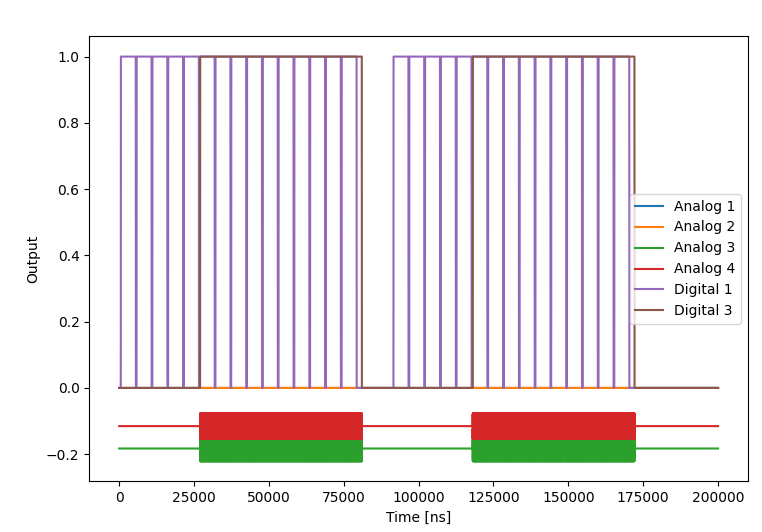!

In [13]:
#Function for a single frequency 

def First_jump_single_freq(Readout_Len, amp_factor, IF_pump, IF_resonator, Offset_IF,Pump_Delay, n_repetition, n_empty,n_full, cooldown_time,qm): 
    
    """ Take as input :
        
        Readout_Len : length of the readout that should be the same as defined in the configuration file. Here, it is necessary for the conversion to volt
        amp_factor : multiplication factor to the pump pulse amplitude
        IF_pump : IF frequency of the pump -> necessary to update the config frequency 
        IF_resonator : If_frequency of the resonator -> necessary to update the config frequency 
        Offset_IF : general ofset if the IF of the resonator is not center 
        Pump_Delay ; time during which the pump is off but we collect datapoints 
        n_repetition : number of times the program is repeated to get an average 
        n_empty : number of measurements when the pulse is off
        n_full : number of measurements when the pulse is on
        cooldown_time : waiting time between repetitions 
        qm : quantum machine 
        """ 

    with program() as IQ_blobs:

        n = declare(int)
        n_rep = declare(int)
        i = declare(int)
        I = declare(fixed)
        Q = declare(fixed)
        I_st = declare_stream()
        Q_st = declare_stream()
        f = declare(int)
        n_rep_st=declare_stream()
        
        assign_variables_to_element("resonator", I,Q) 
    
        #Update the demodulation frequency 
        update_frequency("resonator",IF_resonator+Offset_IF) 
        update_frequency("fluxline",IF_pump)

        #Loop on the repetition 
        with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1):

            #Delay time before turning the pump on 
            wait(Pump_Delay,"fluxline")
            
            #Loop for playing the pump long enough 
            with for_(i, 0, i < np.round((n_full*(Readout_Len+300))/twoPhoton_len)+1, i + 1):
                play("pumping" * amp(amp_factor), 'fluxline')  


            #Demodulation measurements 
            with for_(n, 0, n < n_runs, n + 1):

                #Demodulate n time 
                measure(
                    "fake_readout",
                    "resonator",
                    None,
                    dual_demod.full("cos", "out1", "sin", "out2", I),
                    dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
                )

                save(I, I_st)
                save(Q, Q_st)

            save(n_rep, n_rep_st)

            wait(cooldown_time) #wait the cooldown 

        with stream_processing():
            I_st.with_timestamps().save_all("I")
            Q_st.with_timestamps().save_all("Q")
            n_rep_st.save("n_rep")



    simulation = False    

    if simulation:
        simulation_config = SimulationConfig(
            duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
        )

        job = qmm.simulate(config, IQ_blobs, simulation_config)
        job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

    else:

        job = qm.execute(IQ_blobs)
        results = fetching_tool(job, data_list=["I", "Q","n_rep"], mode="live")

        fig = plt.figure()
        interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure

        while results.is_processing():
            I, Q, n_rep = results.fetch_all()

            #dt=(I["timestamp"][1]-I["timestamp"][0])*1e-9 #time between sucessive points
            time=I["timestamp"]
            I = u.demod2volts(I["value"], Readout_Len) #diviser par la duree du pulse Readout_lEN 
            Q = u.demod2volts(Q["value"], Readout_Len)

            
            plt.subplot(211)
            plt.cla()
            fig.suptitle("IF_pump "+str(IF_pump)+" ite :"+str(n_rep))
            plt.plot(I[:min(len(I), len(Q))], Q[:min(len(I), len(Q))], ".", markersize=2)
            plt.xlabel("I")
            plt.ylabel("Q")
            plt.axis("equal")
            plt.subplot(212)
            plt.cla()
            plt.plot(np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))]), ".", markersize=2)
            plt.plot([n_empty,n_empty], [-np.pi, np.pi],'r')
            plt.xlabel("Nb points")
            plt.ylabel("phase")
            plt.pause(0.1)
    
            
    return I,Q,time
      

In [183]:
%%time
%matplotlib qt
Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

amp_factor=0.25 #Prefactor of the amplitude 

#Update the pump IF frequency 
IF_pump= 0.19695e9 #685e9 #85e9# defines the IF of the pump  
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 

n_repetition=10 #number of repetitions 

n_empty=20_000 #number of vaccum readout to do 
Pump_Delay = n_empty*(Readout_Len+300)//4  #time for the pump to be off 
n_full=80_000 #number of pump on readout to do 
n_runs=n_empty+n_full # Total number of readout to do 

cooldown_time=1_000_000_000//4 #cooldown time before each repetition to go back to vacuum 
Offset_IF=0  

Expected_time=(Readout_Len*n_runs*1e-9*n_repetition+n_repetition*(cooldown_time*4*1e-9+Pump_Delay*4*1e-9))/60


I,Q,time=First_jump_single_freq(Readout_Len, amp_factor, IF_pump, IF_resonator, Offset_IF,Pump_Delay, n_repetition, n_empty,n_full, cooldown_time,qm)


#Reshape to match the different repetitions 
I_2d=I.reshape((n_repetition,n_runs))
Q_2d=Q.reshape((n_repetition,n_runs))
time_2d=time.reshape((n_repetition,n_runs))

2023-04-10 17:43:23,014 - qm - INFO - Flags: 
2023-04-10 17:43:23,015 - qm - INFO - Sending program to QOP
2023-04-10 17:43:23,444 - qm - INFO - Executing program
Wall time: 1min 2s
Execution stopped by user!


## Plotting for single frequency 

Text(0, 0.5, "r'$I^2 + Q^2$ (average) [V]")

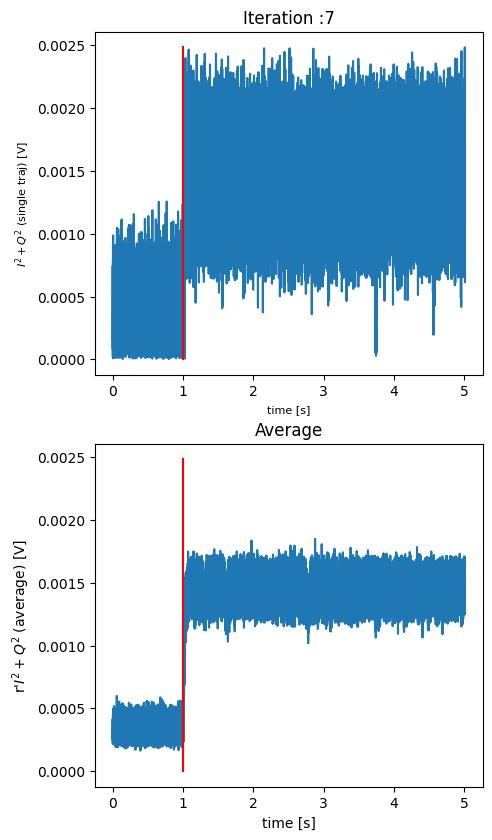

In [184]:
#Single plot 
%matplotlib inline
idx=7 #which iteration 



norm_2d=np.sqrt(I_2d**2+Q_2d**2)
#We reset the timer to zero for each idx
time_2d=(time_2d.transpose()-time_2d[:,0]).transpose()


fontsize=8
fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(5,10),dpi=100)

ax=axs[0]
ax.set_title("Iteration :" + str(idx))
ax.plot(time_2d[idx,:]*1e-9,norm_2d[idx,:])
ax.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, max(norm_2d[idx,:])],"r")
ax.set_ylabel(r'$I^2 + Q^2$ (single traj) [V]',fontsize=fontsize)
ax.set_xlabel("time [s]",fontsize=fontsize)
#average over all axis :
ax=axs[1]
ax.set_title("Average")
av=np.mean(norm_2d,axis=0)
ax.plot(time_2d[0,:]*1e-9,av)
ax.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, max(norm_2d[idx,:])],"r")
ax.set_xlabel("time [s]")
ax.set_ylabel("r'$I^2 + Q^2$ (average) [V]")

              


Text(0, 0.5, "r'$I^2 + Q^2$ (average) [V]")

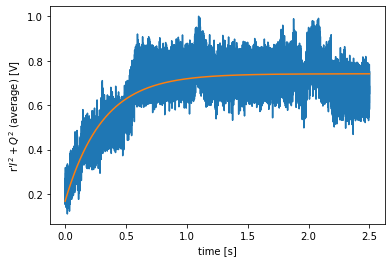

In [172]:
from scipy.optimize import curve_fit

#Two functions : 
def find_nearest(array, value):
    "find nearest value in an array "
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def func(t, A, B, Λ):
    return A + B * np.exp( - Λ * t)

#Rescaling  of the data 
idx_pump_start=find_nearest(time_2d[0,:], Pump_Delay*4) #index at which the pumpt starts 
time_w_pump=time_2d[0,:][idx_pump_start:] # time after the pmup 

number=len(time_w_pump) # how much data to consider for the plot 

time_fit=time_w_pump[0:number]*1e-9-time_2d[0,:][idx_pump_start]*1e-9 #time after the pump substracted by the time of the pump to set to zero
av_fit=av[idx_pump_start:idx_pump_start+number]/max((av[idx_pump_start:idx_pump_start+number])) #normalize data 

#fitting 
popt, pcov = curve_fit(func, time_fit, av_fit, p0 = [1, 0, 0.01] )
y_fitted = popt[0]+  popt[1] * np.exp(-popt[2] * time_fit)

#Plot 
plt.plot(time_fit,av_fit)
plt.plot(time_fit,y_fitted)
plt.xlabel("time [s]")
plt.ylabel("r'$I^2 + Q^2$ (average) [V]")

## Saving for a single frequency

In [283]:
#Saving the data
cooldown_date="2023_03_31" #top folder 
device="Run01" #second folder 
name="104_First_order" # third folder 
meastype="test" #Final file name 

datadict={}
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_pump
datadict["IF_readout"]=IF_resonator
datadict["LO_readout"]=LO_readout


datadict["n_empty"]=n_empty
datadict["n_repetition"]=n_repetition
datadict["n_full"]=n_full
datadict["amp_factor"]=amp_factor
datadict["Offset_IF"]=Offset_IF
datadict["Readout_Len"]=Readout_Len
datadict["Pump_Delay"]=Pump_Delay
datadict["cooldown_time"]=cooldown_time
datadict["I"]=I_2d
datadict["Q"]=Q_2d
datadict["time"]=time_2d
datadict["config"]=config


In [284]:
an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")

saving in new directory


In [7]:
#loading the data 
filepath=r"C:\Users\HQClabo\Documents\Data\gbeaulieu\Two_Photon\2023_03_31\Run01\104_First_order\test.npz"

npzfile=np.load(filepath,allow_pickle=True)
npzfile["multidata"][()]

I_2d=npzfile["multidata"][()]["I"]
Q_2d=npzfile["multidata"][()]["Q"]
time_2d=npzfile["multidata"][()]["time"]
Pump_Delay=npzfile["multidata"][()]["Pump_Delay"]

# Multiple frequencies of single measurement with dual demodualtion 


In [14]:
span=1 * u.MHz # Span of the pumping 
df = 0.05* u.MHz # Step of the pumping 0.01
IF_center=0.19684e9 
freqs = np.arange(IF_center-span/2, IF_center+span/2, df) #sets of frequencies

freqs0=np.array([ 1.9692e+08, 1.9694e+08, 1.9696e+08, 1.9698e+08]) #vacuum 
freqs1=np.arange(0.197e9,0.1971e9+0.00001e9,0.00001e9)# first transition
freqs=np.concatenate((freqs0,freqs1))
freqs

array([1.9692e+08, 1.9694e+08, 1.9696e+08, 1.9698e+08, 1.9700e+08,
       1.9701e+08, 1.9702e+08, 1.9703e+08, 1.9704e+08, 1.9705e+08,
       1.9706e+08, 1.9707e+08, 1.9708e+08, 1.9709e+08, 1.9710e+08])

In [15]:
%matplotlib qt 


# span=1 * u.MHz # Span of the pumping 
# df = 0.05* u.MHz # Step of the pumping 0.01
# IF_center=0.19684e9 
# freqs = np.arange(IF_center-span/2, IF_center+span/2, df) #sets of frequencies

Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

amp_factor=0.25 #Prefactor of the amplitude 

n_repetition=100 #number of repetitions 

n_empty=10_000 #number of vaccum readout to do 
Pump_Delay = n_empty*(Readout_Len+300)//4  #time for the pump to be off 
n_full=80_000 #number of pump on readout to do 
n_runs=n_empty+n_full # Total number of readout to do 

cooldown_time=1_000_000_000//4 #cooldown time before each repetition to go back to vacuum 
Offset_IF=0  


save_Data=True
#Saving the data
cooldown_date="2023_03_31" #top folder 
device="Run01" #second folder 
name="104_First_order" # third folder 
meastype="0p25_amp_100p_after_bug" #Final file name 


print("The different frequency {}".format(freqs))
Expected_time=(Readout_Len*n_runs*1e-9*n_repetition+n_repetition*(cooldown_time*4*1e-9+Pump_Delay*4*1e-9))/60*len(freqs)
print("The expected time : {} min".format(Expected_time))

The different frequency [1.9692e+08 1.9694e+08 1.9696e+08 1.9698e+08 1.9700e+08 1.9701e+08
 1.9702e+08 1.9703e+08 1.9704e+08 1.9705e+08 1.9706e+08 1.9707e+08
 1.9708e+08 1.9709e+08 1.9710e+08]
The expected time : 150.075 min


In [16]:
%%time


Data={} #dictionnary to hold all the data 
for idx,IF_pump in enumerate(freqs) :
    
    print("########################### Frequency "+str(IF_pump+LO_fluxline)+"########################### "+str(idx/len(freqs)))

    IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 
    
    I,Q,time=First_jump_single_freq(Readout_Len, amp_factor, IF_pump, IF_resonator, Offset_IF,Pump_Delay, n_repetition, n_empty,n_full, cooldown_time,qm)
    plt.close()
    
    I_2d=I.reshape((n_repetition,n_runs))
    Q_2d=Q.reshape((n_repetition,n_runs))
    time_2d=time.reshape((n_repetition,n_runs))
    #We reset the timer to zero for each idx
    time_2d=(time_2d.transpose()-time_2d[:,0]).transpose()
    norm_2d=np.sqrt(I_2d**2+Q_2d**2)
    
    Data[IF_pump]={}
    Data[IF_pump]["I"]=I_2d
    Data[IF_pump]["Q"]=Q_2d
    Data[IF_pump]["time"]=time_2d
    Data[IF_pump]["n"]= norm_2d
    
if save_Data:
    
    datadict={}
    datadict["LO_fluxline"]=LO_fluxline
    datadict["IF_fluxline"]=IF_pump
    datadict["IF_readout"]=IF_resonator
    datadict["LO_readout"]=LO_readout


    datadict["n_empty"]=n_empty
    datadict["n_repetition"]=n_repetition
    datadict["n_full"]=n_full
    datadict["amp_factor"]=amp_factor
    datadict["Offset_IF"]=Offset_IF
    datadict["Readout_Len"]=Readout_Len
    datadict["Pump_Delay"]=Pump_Delay
    datadict["cooldown_time"]=cooldown_time
    datadict["Data"]=Data
    datadict["freqs"]=freqs
    datadict["config"]=config
    
    an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")
    
    

########################### Frequency 8696920000.0########################### 0.0
2023-04-11 21:59:59,517 - qm - INFO - Flags: 
2023-04-11 21:59:59,517 - qm - INFO - Sending program to QOP
2023-04-11 21:59:59,938 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8696940000.0########################### 0.06666666666666667
2023-04-11 22:09:30,845 - qm - INFO - Flags: 
2023-04-11 22:09:30,846 - qm - INFO - Sending program to QOP
2023-04-11 22:09:31,268 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8696960000.0########################### 0.13333333333333333
2023-04-11 22:18:59,936 - qm - INFO - Flags: 
2023-04-11 22:18:59,937 - qm - INFO - Sending program to QOP
2023-04-11 22:19:00,695 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8696980000.0########################### 0.2
2023-04-11 22:28:30,144 - qm - INFO - Flags: 
2023-04-11 22:28:30,145 

## Saving for multiple frequencies 

In [ ]:
#Saving the data 
cooldown_date="2023_03_31" #top folder 
device="Run01" #second folder 
name="104_First_order" # third folder 
meastype="test" #Final file name 

datadict={}
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_pump
datadict["IF_readout"]=IF_resonator
datadict["LO_readout"]=LO_readout


datadict["n_empty"]=n_empty
datadict["n_repetition"]=n_repetition
datadict["n_full"]=n_full
datadict["amp_factor"]=amp_factor
datadict["Offset_IF"]=Offset_IF
datadict["Readout_Len"]=Readout_Len
datadict["Pump_Delay"]=Pump_Delay
datadict["cooldown_time"]=cooldown_time
datadict["Data"]=Data
datadict["config"]=config
datadict["freqs"]=freqs

an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")

In [8]:
#Loading the data 

filepath=r"C:\Users\HQClabo\Documents\Data\gbeaulieu\Two_Photon\2023_03_31\Run01\104_First_order\0p25_amp_200p.npz"

npzfile=np.load(filepath,allow_pickle=True)
#npzfile["multidata"][()]

Pump_Delay=npzfile["multidata"][()]["Pump_Delay"]
Data=npzfile["multidata"][()]["Data"]
freqs=npzfile["multidata"][()]["freqs"]

## Plotting for a single frequency 

In [30]:
freqs.shape

(15,)

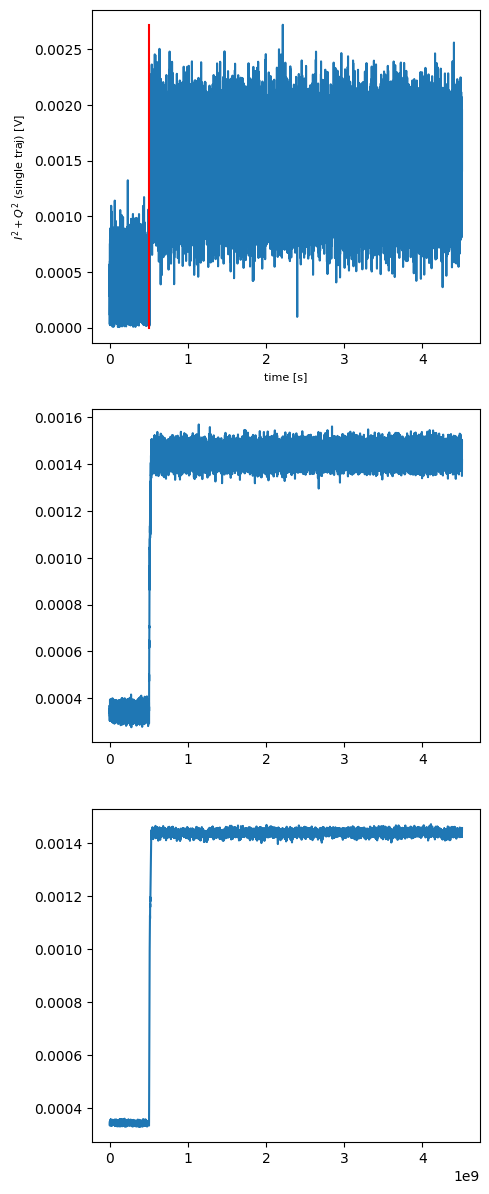

In [29]:
%matplotlib inline
freq_idx=11
it=6
number_avg=10

IF_pump=freqs[freq_idx]
#Reshape to match the different repetitions 
I=Data[IF_pump]["I"][it,:]
n=Data[IF_pump]["n"]
time=Data[IF_pump]["time"][it,:]

fontsize=8
fig, axs = plt.subplots( nrows=3, ncols=1, figsize=(5,15),dpi=100)

ax=axs[0]
ax.plot(time*1e-9,n[it,:])
ax.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, max(n[it,:])],"r")
ax.set_ylabel(r'$I^2 + Q^2$ (single traj) [V]',fontsize=fontsize)
ax.set_xlabel("time [s]",fontsize=fontsize)

#average over all axis :
ax=axs[1]
av=np.mean(n,axis=0)
ax.plot(time*1e-9,av)



time_avg=an.noise_average(time,n=10)
n_avg=an.noise_average(av,n=10)
ax=axs[2]
ax.plot(time_avg,n_avg)


#Averaging the data 
# n_avg=np.zeros((n.shape[0],int(n.shape[1]/number_avg)))
# for i in range(len(freqs)):
#     n_avg[i,:]=an.noise_average(Data[IF_pump]["n"][i,:], n=number_avg)
#     time_avg=an.noise_average(time,n=number_avg)
    
# ax=axs[2]
# ax.plot(time_avg,np.mean(n_avg,axis=0))

## Extracting the Liouivillian gap 

In [286]:
%matplotlib qt
from scipy.optimize import curve_fit

#Two functions : 
def find_nearest(array, value):
    "find nearest value in an array "
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def func(t, A, B, Λ):
    return A + B * np.exp( - Λ * t)


#Rescaling  of the data 
#length to take : 

number=Data[IF_pump]["n"].shape[1]# how much data to consider for the plot 
ploting=True 
figsize=(5,5)
save_plot=True 
fontsize=8
FileName=FileName=r"C:\Users\HQClabo\Documents\Data\gbeaulieu\Two_Photon\2023_03_31\Run01\104_plotting\0p25_First_jump_200_points"

gap=[]
number_avg=10

#for i in range(len(freqs)):

#13,23,1
for i in range(3,15,1):
    
    IF_pump=freqs[i]
    n=Data[IF_pump]["n"]
    time=Data[IF_pump]["time"][0,:] #select the first time 
    
    #average of the data 
    av=np.mean(n,axis=0)
    
    #Take the time, start it at the point where the pump start and then substract the starting time of the pump 
    idx_pump_start=find_nearest(time, Pump_Delay*4) #index at which the pumpt starts 
    time_pump=time[idx_pump_start:]*1e-9 # time after the pmup 

    time_fit=time_pump[0:number]-time[idx_pump_start]*1e-9 #time after the pump substracted by the time of the pump to set to zero
    
    #select the data after the pump
    av_fit=av[idx_pump_start:idx_pump_start+number]
    
    #Normalize the average of the data 
    time_fit=an.noise_average(time_fit,n=number_avg)
    av_fit=an.noise_average(av_fit,n=number_avg)
    av_fit=av_fit /max(av_fit)
    
    
    #fitting 
    popt, pcov = curve_fit(func, time_fit, av_fit, p0 = [1, 0, 0.01] )
    y_fitted = popt[0]+  popt[1] * np.exp(-popt[2] * time_fit)

    gap.append(popt[2])
    
   

    if ploting :
        fig, axs = plt.subplots( nrows=1, ncols=1, figsize=figsize,dpi=200)
        axs.set_title("Pump : "+str(IF_pump) + " Gap: "+str(round(popt[2],2)), fontsize=fontsize)
        axs.plot(time_fit,av_fit)
        axs.plot(time_fit,y_fitted)
        axs.set_xlabel("time from pump on [s]",fontsize=fontsize)
        axs.set_ylabel(r"normalized $I^2 + Q^2$",fontsize=fontsize)
        axs.tick_params(axis='x', labelsize=fontsize)
        axs.tick_params(axis='y', labelsize=fontsize)
        axs.set_ylim((0.2,1))
        
        if save_plot:
            plt.savefig(FileName+f'/img_{i}.png', 
                            transparent = False,  
                            facecolor = 'white'
                           )    
            plt.close()


In [147]:
LO_fluxline

8500000000.0

In [149]:
gap_freq

array([8.69683, 8.69684, 8.69685, 8.69686, 8.69687, 8.69688, 8.69689,
       8.6969 , 8.69691, 8.69692, 8.69693, 8.69694, 8.69695, 8.69696,
       8.69697])

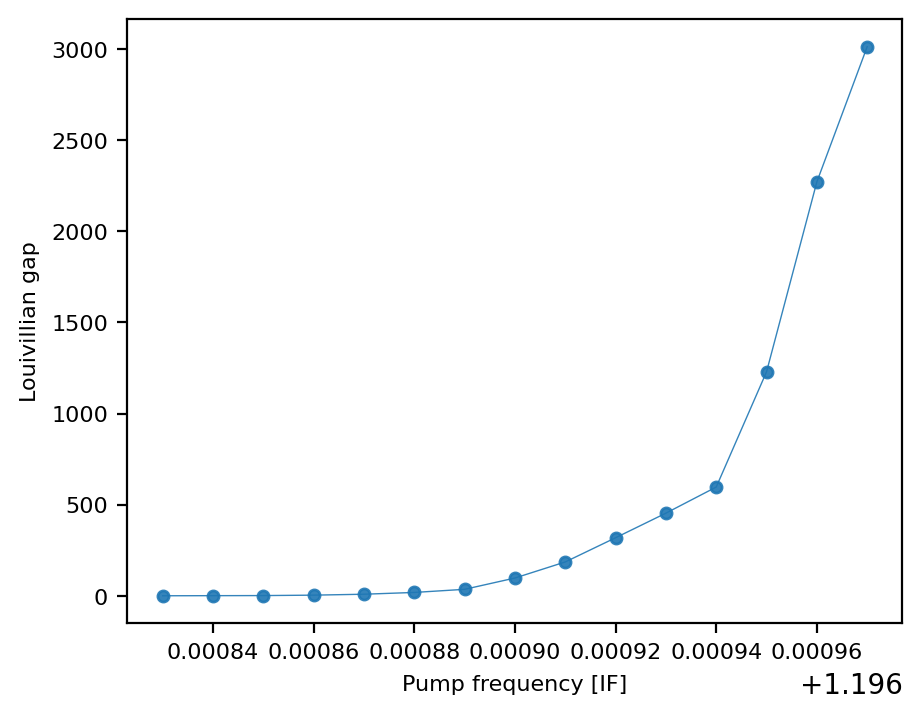

In [159]:
%matplotlib inline
#plt.plot(gap,".")

figsize=(5,4)

fontsize=8

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=figsize,dpi=200)
gap_freq=freqs[13:28]/1e9
axs.plot(gap_freq.tolist(),gap,'.-',alpha=.9, lw=.5, ms=8)
axs.set_xlabel("Pump frequency [IF]",fontsize=fontsize)
axs.set_ylabel("Louivillian gap",fontsize=fontsize)
axs.tick_params(axis='x', labelsize=fontsize)
axs.tick_params(axis='y', labelsize=fontsize)

# Previous 

In [48]:
%matplotlib qt 

Readout_Len=50_000
config,qm=update_readout_lenght(Readout_Len,config,qmm)

amp_factor=0.3 #Prefactor of the amplitude 

#Update the pump IF frequency 
IF_pump= 0.19684e9 #685e9 #85e9# defines the IF of the pump  
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 

n_repetition=10 #number of repetitions 

cooldown_time=10000//4 #cooldown time before each measurement
Offset_IF=0  

n_empty=20_000 #number of vaccum readout to do 
Pump_Delay = n_empty*(Readout_Len+300)//4  #time for the pump to be off 
n_full=50_000 #number of pump on readout to do 
n_runs=n_empty+n_full # Total number of readout to do 

cooldown_time=1_000_000_000//4 #cooldown time before each repetition to go back to vacuum 
Offset_IF=0  

with program() as IQ_blobs:
    
    n = declare(int)
    n_rep = declare(int)
    i = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    f = declare(int)
    
    assign_variables_to_element("resonator", I,Q) 
    n_rep_st=declare_stream()

    update_frequency("resonator",IF_resonator+Offset_IF) 
    update_frequency("fluxline",IF_pump)
    
    with for_(n_rep, 0, n_rep < n_repetition, n_rep + 1):
    
        #Delay time before turning the pump on 
        wait(Pump_Delay,"fluxline")

        with for_(i, 0, i < np.round((n_full*(Readout_Len+300))/twoPhoton_len)+1, i + 1):
            play("pumping" * amp(amp_factor), 'fluxline')  

       
        
        with for_(n, 0, n < n_runs, n + 1):

            #Demodulate n time 
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            save(I, I_st)
            save(Q, Q_st)
            
        save(n_rep, n_rep_st)
            
        wait(cooldown_time) #wait the cooldown 

    with stream_processing():
        I_st.with_timestamps().save_all("I")
        Q_st.with_timestamps().save_all("Q")
        n_rep_st.save("n_rep")

        
        
simulation = False    

if simulation:
    simulation_config = SimulationConfig(
        duration=50000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    
    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

    
    
else:
  

    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q","n_rep"], mode="live")
    
    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    
    while results.is_processing():
        I, Q, n_rep = results.fetch_all()
        
        #dt=(I["timestamp"][1]-I["timestamp"][0])*1e-9 #time between sucessive points
        time=I["timestamp"]
        I = u.demod2volts(I["value"], pulse_len) #diviser par la duree du pulse 
        Q = u.demod2volts(Q["value"], pulse_len)

        plt.title("IQ blobs")
        plt.subplot(211)
        plt.cla()
        plt.plot(I[:min(len(I), len(Q))], Q[:min(len(I), len(Q))], ".", markersize=2)
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.axis("equal")
        plt.subplot(212)
        plt.cla()
        tau=np.linspace(1,min(len(I), len(Q)),min(len(I), len(Q)))
        plt.plot(tau,np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))]), ".", markersize=2)
        plt.plot([n_empty,n_empty], [-np.pi, np.pi],'r')
        plt.xlabel("Nb points")
        plt.ylabel("phase")
        plt.pause(0.1)
      

2023-04-09 16:10:04,588 - qm - INFO - Flags: 
2023-04-09 16:10:04,588 - qm - INFO - Sending program to QOP
2023-04-09 16:10:05,094 - qm - INFO - Executing program
Execution stopped by user!


In [42]:
I_r

array([[ 2.12924194e-03, -1.29621887e-03, -4.00413513e-03, ...,
         3.82824173e-02,  3.10856018e-02,  5.02313995e-02],
       [ 1.34589386e-03, -1.10350037e-02,  1.27498703e-02, ...,
        -2.53733139e-02, -4.62429657e-02, -4.17375336e-02],
       [ 6.77490234e-06, -1.56404877e-03, -3.04701233e-03, ...,
         4.12884598e-02,  2.48889008e-02,  3.71614151e-02],
       ...,
       [ 1.44785461e-02, -1.39583359e-02, -1.37122345e-03, ...,
        -3.69087143e-02, -4.02715454e-02, -2.71119003e-02],
       [-3.29916382e-03, -3.56618500e-03,  9.43539429e-03, ...,
        -3.82577515e-02, -3.94027557e-02, -4.09419479e-02],
       [ 2.43622589e-03, -5.31639099e-04,  5.14384460e-03, ...,
         4.76587143e-02,  3.31960754e-02,  4.36918335e-02]])

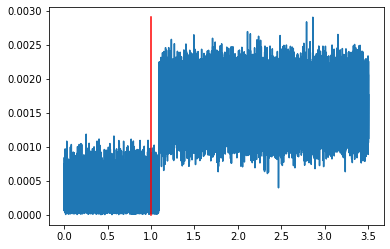

In [72]:
%matplotlib inline
I_r=I.reshape((n_repetition,n_runs))
Q_r=Q.reshape((n_repetition,n_runs))

time_r=time.reshape((n_repetition,n_runs))

idx=8

maxi=max(np.sqrt(I_r[idx,:]**2+Q_r[idx,:]**2))
plt.plot(time_r[idx,:]*1e-9-time_r[idx,0]*1e-9,np.sqrt(I_r[idx,:]**2+Q_r[idx,:]**2))
plt.plot([Pump_Delay*4*1e-9,Pump_Delay*4*1e-9],[0, maxi],"r")

In [130]:
n_empty*50_000*1e-9

1.0

## Multiple frequencies with dual demodulation 

Need to make sure that the new updated IF frequency doesn't go over 350 MHz.
Need to make sure that the readout_len * n_runs is much larger than the pump delay
Note : the maximum number of variables that can be steamed is 100e6. if there is a timestamp attached to it, it will be doubled

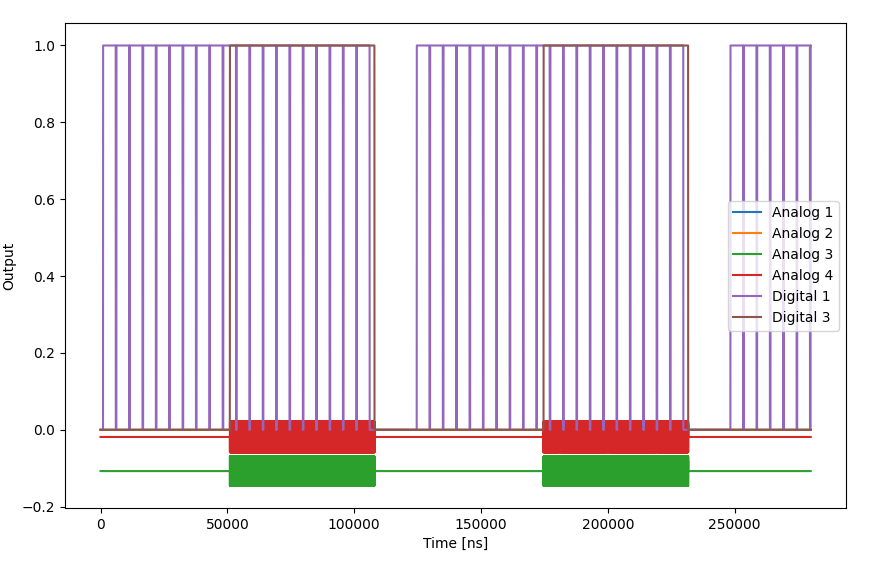

In [22]:
#Variables setting for the program 

Readout_Len=5_000#length of the readout pulse in ns 
config,qm=update_readout_lenght(Readout_Len,config,qmm)

n_runs = 20 #Number of readout to do 

span=1.5 * u.MHz # Span of the pumping 
df = 0.1* u.MHz # Step of the pumping 0.01
IF_center=0.262e9 
freqs = np.arange(IF_center-span/2, IF_center+span/2, df) #sets of pump frequencies 
Offset_IF=0  #-5670.0 +400 #+1000 #+10000
LO_diff=LO_fluxline/2-LO_readout # need to perform this substraction outside of the qua program to avoid having numbers larger than the int allowed 

Pump_Delay=50000//4 # Delay before starting the pump 
cooldown_time_pump = 16000 // 4 # Time delay between applying sucessive pumps upgrading the frequency 

amp_factor=0.3 #Prefactor of the amplitude of the pump 


#Saving the data 
cooldown_date="2023_02_24" #top folder 
device="123" #second folder 
name="Run01" # third folder 
meastype="100ms_1ms_0p4" #Final file name 
datadict={}

#Program time and memory prediction
NumberPoints=n_runs*freqs.shape[0]
print("The Numbber of points is : {}".format(NumberPoints))
print("The fraction from maximum buffer capability is : {}".format(NumberPoints*2/100e6))
print("The estimated time per trace is {} minutes".format((n_runs*(Readout_Len*1e-9))/60))
print("The total estimated time {} minutes".format((NumberPoints*(Readout_Len*1e-9))/60))

The Numbber of points is : 300
The fraction from maximum buffer capability is : 6e-06
The estimated time per trace is 1.6666666666666667e-06 minutes
The total estimated time 2.5e-05 minutes


In [24]:
%%time
%matplotlib qt


with program() as IQ_blobs:
    
    n = declare(int)
    i = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    assign_variables_to_element("resonator", I,Q) #This line forces the OPX to assign I and Q to the resonator element such that the loops can happen in parallel as intented
    I_st = declare_stream() # Data paths
    Q_st = declare_stream() # Data paths
    
    
    f = declare(int)
    f_readout = declare(int)
   

    with for_(*from_array(f,freqs)):  # loop over the frequency array 
        
        assign(f_readout,LO_diff+f/2+Offset_IF) #update the readout frequency to be 1/2 of the pump frequency 
        update_frequency("resonator",f_readout) # Change the IF frequency of the resonator to demodulate more precisely 
        update_frequency("fluxline",f) # updates the IF frequency to the array 
        
    
         #Delay time before turning the pump on 
        wait(Pump_Delay,"fluxline")
        with for_(i, 0, i < np.round((n_runs*(Readout_Len+300)-Pump_Delay*4)/twoPhoton_len)+1, i + 1): # the 300 is added because there is a time delay associated to saving the data in the steam. The *4 is necessary because the waiting time is in clockcycle 
            play("pumping" * amp(amp_factor), 'fluxline')  # Play the pulse on the fluxline
            
        
        with for_(n, 0, n < n_runs, n + 1):

            #Demodulate for the length 
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            save(I, I_st) # Save data to path
            save(Q, Q_st) # Save data to path 

            
        #waiting time before the next pump     
        wait(cooldown_time_pump)
        

    with stream_processing():
        I_st.with_timestamps().save_all("I") 
        Q_st.with_timestamps().save_all("Q")
        

        
simulation = True  

if simulation: 
    simulation_config = SimulationConfig(
        duration=70000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    
    job = qmm.simulate(config, IQ_blobs, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

    
    
else:
  
    job = qm.execute(IQ_blobs)
    results = fetching_tool(job, data_list=["I", "Q"], mode="live")
    
    # Live plotting
    fig = plt.figure()
    interrupt_on_close(fig, job)  #  Interrupts the job when closing the figure
    
    while results.is_processing():
        I, Q = results.fetch_all()
        
        dt=(I["timestamp"][1]-I["timestamp"][0])*1e-9 #time between sucessive points
        
        I = u.demod2volts(I["value"], pulse_len) #diviser par la duree du pulse 
        Q = u.demod2volts(Q["value"], pulse_len)

        #plotting 
        plt.title("IQ blobs")
        plt.subplot(211)
        plt.cla()
        plt.plot(I[:min(len(I), len(Q))], Q[:min(len(I), len(Q))], ".", markersize=2)
        plt.xlabel("I")
        plt.ylabel("Q")
        plt.axis("equal")
        plt.subplot(212)
        plt.cla()
        tau=np.linspace(1,min(len(I), len(Q)),min(len(I), len(Q)))
        plt.plot(np.unwrap(np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))])), ".", markersize=2)
        plt.xlabel("Nb points")
        plt.ylabel("phase")
        plt.pause(0.1)
       
        
        
        
#Saving 
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_fluxline"]=IF_fluxline
datadict["IF_readout"]=IF_readout
datadict["LO_readout"]=LO_readout
datadict["freqs"]=freqs

datadict["n_runs"]=n_runs
datadict["amp_factor"]=amp_factor
datadict["Offset_IF"]=Offset_IF
datadict["Readout_Len"]=Readout_Len
datadict["Pump_Delay"]=Pump_Delay
datadict["cooldown_time_pump"]=cooldown_time_pump
datadict["config"]=config 
datadict["I"]=I.reshape((freqs.shape[0],n_runs))
datadict["Q"]=Q.reshape((freqs.shape[0],n_runs))
datadict["dt"]=dt

#an.save_data(datadict, meastype, name, device, cooldown_date, bias=0, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")

2023-04-03 09:32:06,924 - qm - INFO - Flags: 
2023-04-03 09:32:06,924 - qm - INFO - Simulating program
Wall time: 20.1 s


In [ ]:
#Plotting of the different data sets taken 
I_r=I.reshape((freqs.shape[0],n_runs))
Q_r=Q.reshape((freqs.shape[0],n_runs))

plt.close("all") # close all open figures 
for i in range(freqs.shape[0]): # for all frequency, we create the two plot 
    fig = plt.figure()
    plt.subplot(211)
    plt.plot(I_r[i,:], Q_r[i,:], ".", markersize=2)
    plt.xlabel("I (V)")
    plt.ylabel("Q (V)")
    plt.axis("equal")
    plt.title("Pump Frequency : " +str((LO_fluxline+freqs[i])/1e9)+" GHz")
    plt.subplot(212)
    time=np.linspace(1,len(I_r[i,:]), len(I_r[i,:]),len(I_r[i,:]))*dt # time in seconds 
    plt.plot(time,(np.angle(I_r[i,:]+1j*Q_r[i,:]), ".", markersize=2)
    plt.xlabel("Time (us)")
    plt.ylabel("Phase")
    